In [1]:
import os
import re
from pathlib import Path

# ---------------------------------------------------------
# lithodata 아래 지정한 데이터셋 폴더만 순회합니다.
# 실행 위치가 달라도 자동으로 루트를 찾습니다.
DATASET_NAMES = [
    "MetalSet",
    "StdMetal",
    "StdContact",
    "StdContactTest",
    "ViaSet",
]

def resolve_base_root() -> Path:
    # 1) 현재 작업 디렉터리 기준
    cwd = Path.cwd()
    candidate = cwd / "LithoBench" / "0_Datasets" / "lithodata"
    if candidate.exists():
        return candidate

    # 2) 상위 폴더를 올라가며 탐색
    for parent in [cwd, *cwd.parents]:
        candidate = parent / "LithoBench" / "0_Datasets" / "lithodata"
        if candidate.exists():
            return candidate

    # 3) 현재 위치가 LithoBench 내부인 경우
    for parent in [cwd, *cwd.parents]:
        if parent.name == "LithoBench":
            candidate = parent / "0_Datasets" / "lithodata"
            if candidate.exists():
                return candidate

    raise FileNotFoundError("데이터셋 루트를 찾을 수 없습니다. 작업 경로를 확인하세요.")

base_root = resolve_base_root()
# ---------------------------------------------------------

# 지원하는 이미지 확장자
IMAGE_EXTS = [".png", ".jpg", ".jpeg"]

def inspect_glp_scale(glp_path: Path):
    if not glp_path.exists():
        print(f"파일을 찾을 수 없습니다: {glp_path}")
        return None, None, None

    with glp_path.open("r") as f:
        content = f.readlines()

    max_x, max_y = 0, 0
    unit_info = "정보 없음"

    print(f"--- 분석 파일: {glp_path.name} ---")

    for line in content:
        line = line.strip()

        # 1. 단위(EQUV) 정보 찾기
        if line.startswith("EQUV"):
            # 예: EQUV 1 1000 MICRON
            print(f"📝 단위 정보 발견: {line}")
            unit_info = line.split()

        # 2. 좌표 범위 찾기 (RECT, PGON)
        # 포맷 가정: RECT N M1 x y w h
        if line.startswith("RECT") or line.startswith("PGON"):
            parts = line.split()
            # 좌표들은 보통 3번째 인덱스 뒤에 나옵니다. 숫자만 추출
            coords = [int(p) for p in parts if p.replace("-", "").isdigit()]
            if coords:
                max_x = max(max_x, max(coords))
                max_y = max(max_y, max(coords))

    print(f"📏 좌표 최대값 (Max Coordinate): X={max_x}, Y={max_y}")
    return unit_info, max_x, max_y


def find_target_image(target_dir: Path, stem: str) -> Path | None:
    for ext in IMAGE_EXTS:
        candidate = target_dir / f"{stem}{ext}"
        if candidate.exists():
            return candidate
    return None


import cv2
import numpy as np

if not base_root.exists():
    raise FileNotFoundError(f"데이터셋 루트를 찾을 수 없습니다: {base_root}")


def read_image_gray(path: Path):
    # Windows + 한글 경로에서 cv2.imread가 실패하는 경우가 있어 우회
    data = np.fromfile(str(path), dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
    return img


# 지정한 데이터셋 폴더 순회
for dataset_name in DATASET_NAMES:
    dataset_dir = base_root / dataset_name
    if not dataset_dir.exists():
        print(f"\n[주의] 데이터셋 폴더 없음: {dataset_dir}")
        continue

    glp_dir = dataset_dir / "glp"
    target_dir = dataset_dir / "target"

    if not glp_dir.exists():
        print(f"\n[주의] glp 폴더 없음: {glp_dir}")
        continue

    print(f"\n===== 데이터셋: {dataset_dir.name} =====")

    for glp_path in sorted(glp_dir.glob("*.glp")):
        unit_info, glp_max_x, glp_max_y = inspect_glp_scale(glp_path)
        if glp_max_x is None:
            continue

        target_path = find_target_image(target_dir, glp_path.stem) if target_dir.exists() else None
        if target_path and target_path.exists():
            img = read_image_gray(target_path)
            if img is None:
                print(f"[주의] 이미지 로드 실패: {target_path}")
                continue
            h, w = img.shape
            print(f"🖼️ 대응되는 이미지 크기: {w} x {h} pixels")
            print("\n[분석 결과]")
            print(f"이미지 1픽셀 = GLP 좌표 {glp_max_x / w:.2f} 단위")
        else:
            print("\n[주의] 대응되는 이미지 파일을 찾지 못했습니다. 경로를 확인해주세요.")

# ===============================
# 결과 저장 (CSV + TXT + 요약)
# ===============================
import pandas as pd

# 1. DataFrame 생성
df = pd.DataFrame({
    "mask_complexity_nm2": complexity_scores,
    "final_error_nm2": l2_errors,
    "pattern_density": densities
})

# 2. 저장 경로
save_dir = base_root / subset
csv_path = save_dir / "physical_metrics.csv"
txt_path = save_dir / "physical_metrics.txt"
summary_path = save_dir / "summary.txt"

# 3. CSV 저장
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

# 4. TXT 저장
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("mask_complexity_nm2\tfinal_error_nm2\tpattern_density\n")
    for c, e, d in zip(complexity_scores, l2_errors, densities):
        f.write(f"{c:.6f}\t{e:.6f}\t{d:.6f}\n")

# 5. 요약 통계 저장 (논문/보고서용)
corr = np.corrcoef(complexity_scores, l2_errors)[0, 1]

with open(summary_path, "w", encoding="utf-8") as f:
    f.write(f"Subset: {subset}\n")
    f.write(f"Num samples: {len(complexity_scores)}\n")
    f.write(f"Scale: 1px = {scale_nm_per_px} nm\n")
    f.write(f"Correlation (Mask Complexity vs Final Error): {corr:.4f}\n")

print("✅ 결과 저장 완료")
print(f"- CSV     : {csv_path}")
print(f"- TXT     : {txt_path}")
print(f"- SUMMARY : {summary_path}")



===== 데이터셋: MetalSet =====
--- 분석 파일: cell0.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordinate): X=716, Y=716
🖼️ 대응되는 이미지 크기: 2048 x 2048 pixels

[분석 결과]
이미지 1픽셀 = GLP 좌표 0.35 단위
--- 분석 파일: cell1.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordinate): X=616, Y=616
🖼️ 대응되는 이미지 크기: 2048 x 2048 pixels

[분석 결과]
이미지 1픽셀 = GLP 좌표 0.30 단위
--- 분석 파일: cell10.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordinate): X=916, Y=916
🖼️ 대응되는 이미지 크기: 2048 x 2048 pixels

[분석 결과]
이미지 1픽셀 = GLP 좌표 0.45 단위
--- 분석 파일: cell100.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordinate): X=956, Y=956
🖼️ 대응되는 이미지 크기: 2048 x 2048 pixels

[분석 결과]
이미지 1픽셀 = GLP 좌표 0.47 단위
--- 분석 파일: cell1000.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordinate): X=873, Y=873
🖼️ 대응되는 이미지 크기: 2048 x 2048 pixels

[분석 결과]
이미지 1픽셀 = GLP 좌표 0.43 단위
--- 분석 파일: cell10000.glp ---
📝 단위 정보 발견: EQUV  1  1000  MICRON  +X,+Y
📏 좌표 최대값 (Max Coordin

KeyboardInterrupt: 

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# 1. 경로 설정 (자동 탐색)
def resolve_base_root() -> Path:
    cwd = Path.cwd()
    for parent in [cwd, *cwd.parents]:
        candidate = parent / "LithoBench" / "0_Datasets" / "lithodata"
        if candidate.exists(): return candidate
        if parent.name == "LithoBench":
             return parent / "0_Datasets" / "lithodata"
    raise FileNotFoundError("데이터셋 루트를 찾을 수 없습니다.")

base_root = resolve_base_root()

# 2. 분석할 데이터셋 정의 (3종 비교)
# StdMetal과 StdContact를 합쳐서 볼 수도 있지만, 일단 StdMetal을 대표로 봅니다.
target_datasets = [
    {"name": "MetalSet", "color": "red", "label": "Metal (Random Logic)"},
    {"name": "ViaSet", "color": "blue", "label": "Via (Holes)"},
    {"name": "StdMetal", "color": "green", "label": "StdSet (Standard Cell)"} 
]

plt.figure(figsize=(12, 6))

for item in target_datasets:
    d_name = item["name"]
    target_dir = base_root / d_name / "target"
    
    if not target_dir.exists():
        print(f"⚠️ Skipping {d_name} (폴더 없음)")
        continue
        
    files = list(target_dir.glob("*.png")) + list(target_dir.glob("*.jpg"))
    
    # 데이터가 너무 많으면 500개 샘플링, 적으면 전체 다 사용
    if len(files) > 500:
        files = np.random.choice(files, 500, replace=False)
    elif len(files) == 0:
        print(f"⚠️ {d_name}에 이미지 파일이 없습니다.")
        continue
    
    print(f"📊 Analyzing {d_name} ({len(files)} samples)...")
    
    densities = []
    for f in tqdm(files, leave=False):
        # 한글 경로 호환 로드
        data = np.fromfile(str(f), dtype=np.uint8)
        img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
            
        # 정규화 및 밀도 계산 (0~1)
        img_norm = img / 255.0
        densities.append(np.mean(img_norm))
        
    # 히스토그램 그리기 (투명도 조절로 겹쳐서 보이게 함)
    plt.hist(densities, bins=50, alpha=0.4, color=item["color"], 
             label=item["label"], density=True, edgecolor=item["color"], linewidth=1.2)

# 그래프 꾸미기
plt.title("Dataset Pattern Density Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Pattern Density (0=Empty, 1=Full)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(0, 1.0) # 0~100% 범위 고정

plt.tight_layout()
plt.show()

📊 Analyzing MetalSet (500 samples)...


KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# 1. 경로 자동 설정
def resolve_base_root() -> Path:
    cwd = Path.cwd()
    for parent in [cwd, *cwd.parents]:
        candidate = parent / "LithoBench" / "0_Datasets" / "lithodata"
        if candidate.exists(): return candidate
        if parent.name == "LithoBench":
             return parent / "0_Datasets" / "lithodata"
    raise FileNotFoundError("데이터셋 루트를 찾을 수 없습니다.")

base_root = resolve_base_root()

# 2. 분석 설정
subset = "StdContact" # 가장 복잡한 MetalSet을 분석하는 게 의미가 큼
scale_nm_per_px = 0.5 # 아까 GLP 분석에서 얻은 값 (1px = 0.5nm 가정)

# 저장 리스트
complexity_scores = [] # 마스크 복잡도 (L1 Norm of change)
l2_errors = []         # 최종 에러 (L2 Norm)
densities = []         # 패턴 밀도

target_dir = base_root / subset / "target"
mask_dir = base_root / subset / "pixelILT"
resist_dir = base_root / subset / "resist"

# 파일 목록 가져오기
files = list(target_dir.glob("*.png")) + list(target_dir.glob("*.jpg"))
if len(files) > 500: # 500개 샘플링
    files = np.random.choice(files, 500, replace=False)

print(f"🔬 {subset} 물리적 특성 분석 시작 (Scale: 1px = {scale_nm_per_px}nm)...")

for f in tqdm(files):
    # 파일명 매칭 (확장자가 다를 수 있음 고려)
    stem = f.stem
    
    # 각 폴더에서 해당 파일 찾기
    path_m = None
    path_r = None
    
    for ext in ['.png', '.jpg']:
        if (mask_dir / (stem + ext)).exists(): path_m = mask_dir / (stem + ext)
        if (resist_dir / (stem + ext)).exists(): path_r = resist_dir / (stem + ext)
    
    if not (path_m and path_r): continue

    # 이미지 로드 (Gray) & 정규화 (0~1)
    img_t = cv2.imdecode(np.fromfile(str(f), dtype=np.uint8), cv2.IMREAD_GRAYSCALE) / 255.0
    img_m = cv2.imdecode(np.fromfile(str(path_m), dtype=np.uint8), cv2.IMREAD_GRAYSCALE) / 255.0
    img_r = cv2.imdecode(np.fromfile(str(path_r), dtype=np.uint8), cv2.IMREAD_GRAYSCALE) / 255.0
    
    # -----------------------------------------------------------
    # [핵심 수치 계산]
    # 1. Mask Complexity: Target과 Mask가 얼마나 다른가? (픽셀 단위 Sum)
    # -> 값이 클수록 ILT(보정)가 격렬하게 일어났다는 뜻
    mask_diff = np.sum(np.abs(img_t - img_m)) * (scale_nm_per_px ** 2) # nm^2 면적
    
    # 2. Reconstruction Error: Target과 Resist(결과)가 얼마나 다른가?
    # -> 값이 클수록 불량(Hotspot)일 확률 높음
    rec_error = np.sum(np.abs(img_t - img_r)) * (scale_nm_per_px ** 2) # nm^2 면적
    
    # 3. Density
    density = np.mean(img_t)
    # -----------------------------------------------------------
    
    complexity_scores.append(mask_diff)
    l2_errors.append(rec_error)
    densities.append(density)

# 시각화
plt.figure(figsize=(12, 5))

# 그래프 1: 복잡도 vs 에러 (Correction Efficiency)
plt.subplot(1, 2, 1)
plt.scatter(complexity_scores, l2_errors, alpha=0.6, c=densities, cmap='viridis')
plt.title(f"Mask Complexity vs. Error ({subset})")
plt.xlabel("Correction Amount (Mask Change Area in $nm^2$)")
plt.ylabel("Final Error (Mismatch Area in $nm^2$)")
plt.colorbar(label="Pattern Density")
plt.grid(True, linestyle='--', alpha=0.3)

# 그래프 2: 밀도 vs 에러 (Difficulty)
plt.subplot(1, 2, 2)
plt.scatter(densities, l2_errors, alpha=0.6, color='coral')
plt.title(f"Pattern Density vs. Error ({subset})")
plt.xlabel("Pattern Density (0~1)")
plt.ylabel("Final Error ($nm^2$)")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()



🔬 StdContact 물리적 특성 분석 시작 (Scale: 1px = 0.5nm)...


 15%|█▌        | 25/163 [00:04<00:23,  5.84it/s]


KeyboardInterrupt: 

🚨 Top 5 Worst Error Samples Analysis (All Stages)


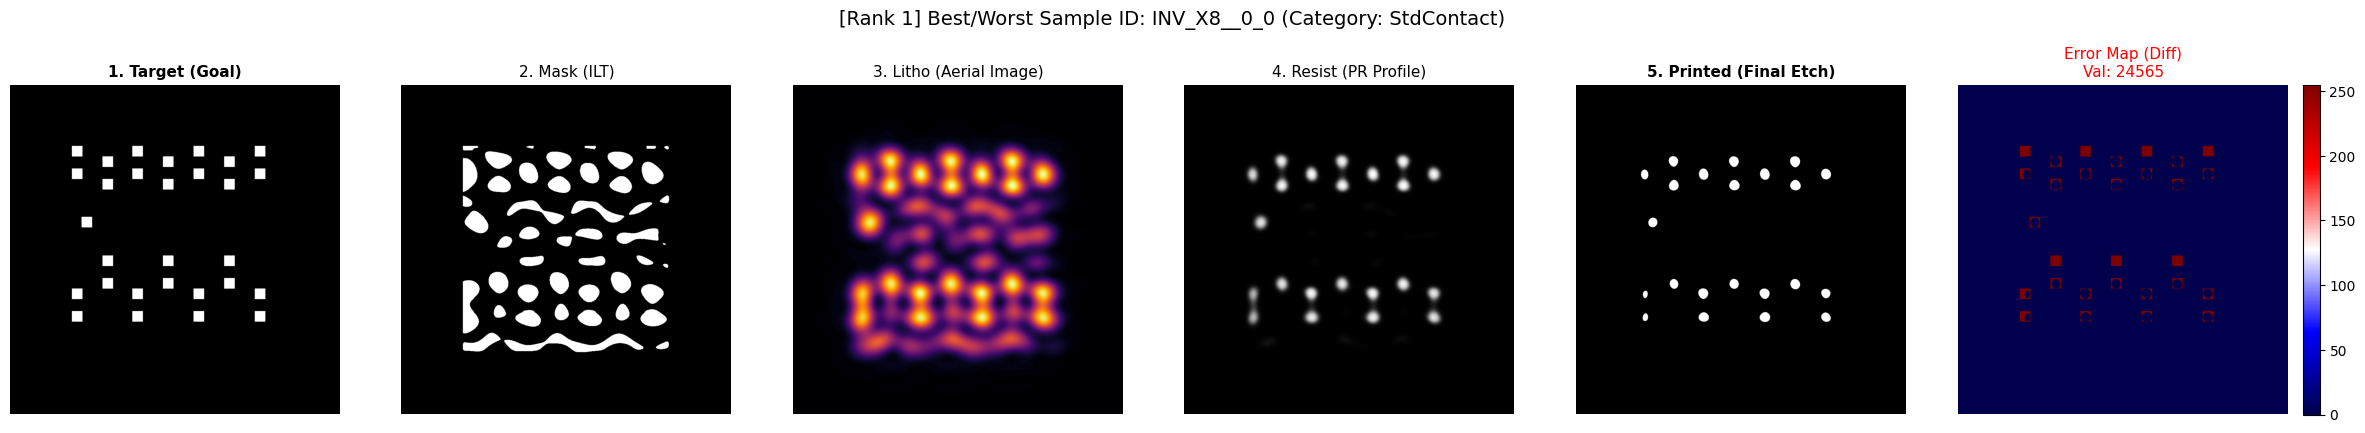

----------------------------------------------------------------------------------------------------


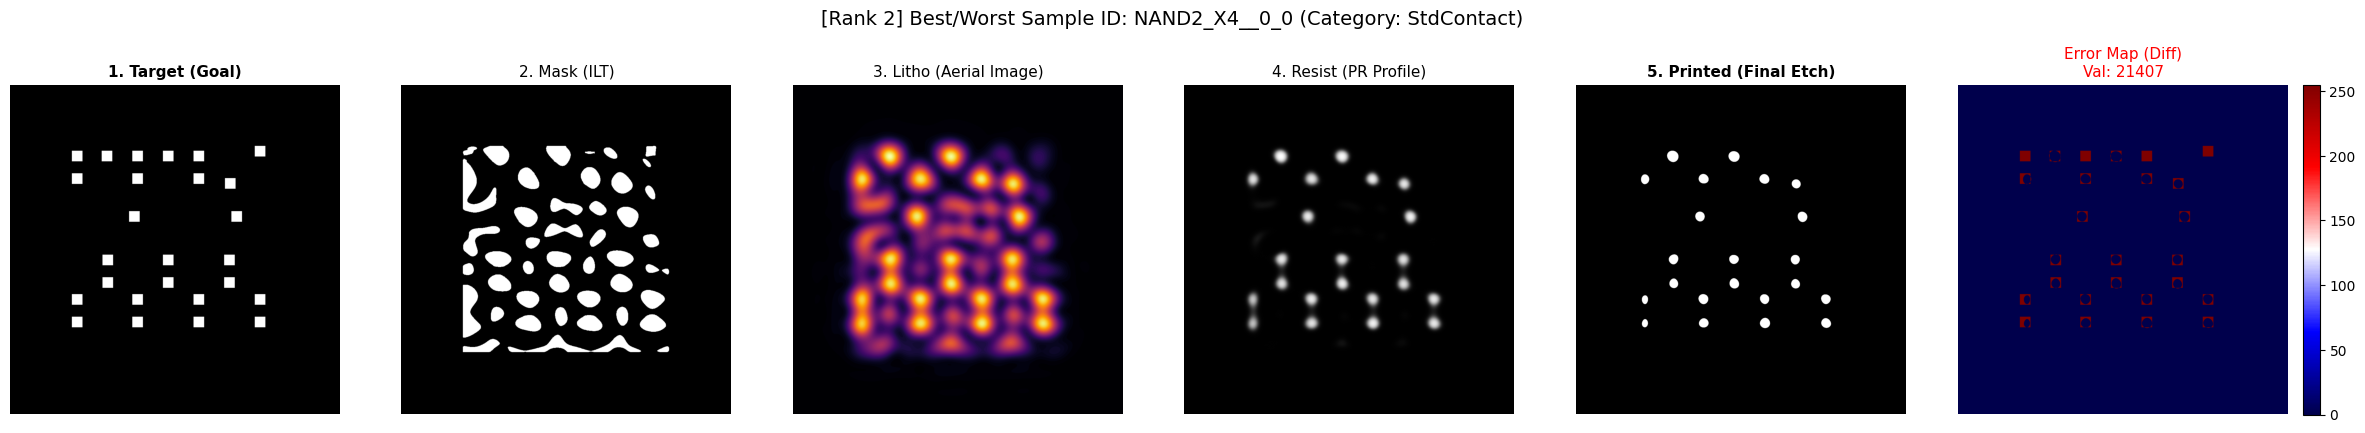

----------------------------------------------------------------------------------------------------


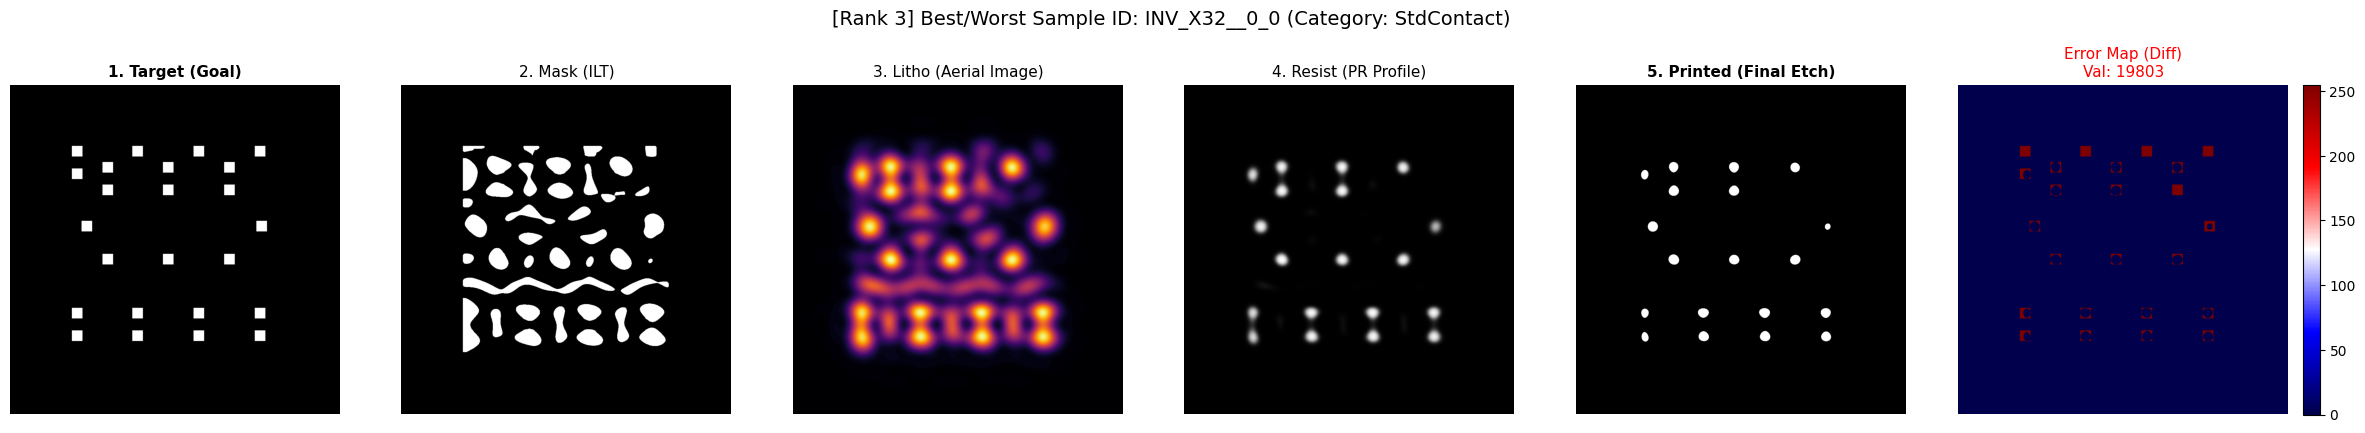

----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pathlib import Path

# ==========================================
# 1. 설정 및 인덱스 추출
# ==========================================
# 에러가 큰 순서대로 정렬 (l2_errors는 이전 단계에서 계산됨)
sorted_indices = np.argsort(l2_errors)[::-1][:15]

print(f"🚨 Top 5 Worst Error Samples Analysis (All Stages)")
print("=" * 100)

# ==========================================
# 2. 시각화 루프
# ==========================================
for i, idx in enumerate(sorted_indices):
    f_path = Path(files[idx])  # target 파일 경로 (예: .../StdMetal/target/sample.png)
    
    # 1. 경로 자동 추론 (상위 폴더 기반)
    # f_path.parent -> 'target' 폴더
    # f_path.parent.parent -> 'StdMetal' (카테고리) 폴더
    base_dir = f_path.parent.parent 
    fname = f_path.name  # 파일명 (예: 1.png)
    
    # 각 폴더별 경로 설정
    path_target  = f_path
    path_mask    = base_dir / 'pixelILT' / fname
    path_litho   = base_dir / 'litho' / fname
    path_resist  = base_dir / 'resist' / fname
    path_printed = base_dir / 'printed' / fname
    
    # 2. 이미지 로드 함수 (없으면 None 반환)
    def load_img(path):
        if path.exists():
            return cv2.imdecode(np.fromfile(str(path), dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        return None

    img_t = load_img(path_target)
    img_m = load_img(path_mask)
    img_l = load_img(path_litho)
    img_r = load_img(path_resist)
    img_p = load_img(path_printed)
    
    # 파일 누락 시 건너뛰기
    if any(x is None for x in [img_t, img_m, img_l, img_r, img_p]):
        print(f"Skipping Rank {i+1} ({fname}): Some files are missing.")
        continue

    # 3. Error Map 계산 (Target vs Printed)
    # 최종 결과물인 Printed와 목표인 Target의 차이를 봅니다.
    error_map = cv2.absdiff(img_t, img_p)

    # ==========================================
    # 3. 그래프 그리기 (1행 6열)
    # ==========================================
    plt.figure(figsize=(24, 4)) # 가로로 길게 설정
    
    # (1) Target (입력)
    plt.subplot(1, 6, 1)
    plt.imshow(img_t, cmap='gray')
    plt.title("1. Target (Goal)", fontsize=11, fontweight='bold')
    plt.axis('off')
    plt.ylabel(f"Rank {i+1}", fontsize=12)
    
    # (2) Pixel ILT (마스크)
    plt.subplot(1, 6, 2)
    plt.imshow(img_m, cmap='gray')
    plt.title("2. Mask (ILT)", fontsize=11)
    plt.axis('off')
    
    # (3) Litho (광학 이미지)
    plt.subplot(1, 6, 3)
    plt.imshow(img_l, cmap='inferno') # 빛의 분포이므로 컬러맵 적용 추천
    plt.title("3. Litho (Aerial Image)", fontsize=11)
    plt.axis('off')

    # (4) Resist (PR 프로파일)
    plt.subplot(1, 6, 4)
    plt.imshow(img_r, cmap='gray')
    plt.title("4. Resist (PR Profile)", fontsize=11)
    plt.axis('off')

    # (5) Printed (최종 결과)
    plt.subplot(1, 6, 5)
    plt.imshow(img_p, cmap='gray')
    plt.title("5. Printed (Final Etch)", fontsize=11, fontweight='bold')
    plt.axis('off')

    # (6) Error Map (차이)
    plt.subplot(1, 6, 6)
    im = plt.imshow(error_map, cmap='seismic') # 차이는 빨강/파랑 강조
    plt.title(f"Error Map (Diff)\nVal: {l2_errors[idx]:.0f}", fontsize=11, color='red')
    plt.colorbar(im, fraction=0.046, pad=0.04) # 컬러바 추가
    plt.axis('off')

    plt.suptitle(f"[Rank {i+1}] Best/Worst Sample ID: {f_path.stem} (Category: {base_dir.name})", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    print("-" * 100)